### Simple step by step approach with shake-shake regularization for Bengali AI competition . If its useful for you please upvote .

The paper is here https://arxiv.org/abs/1705.07485

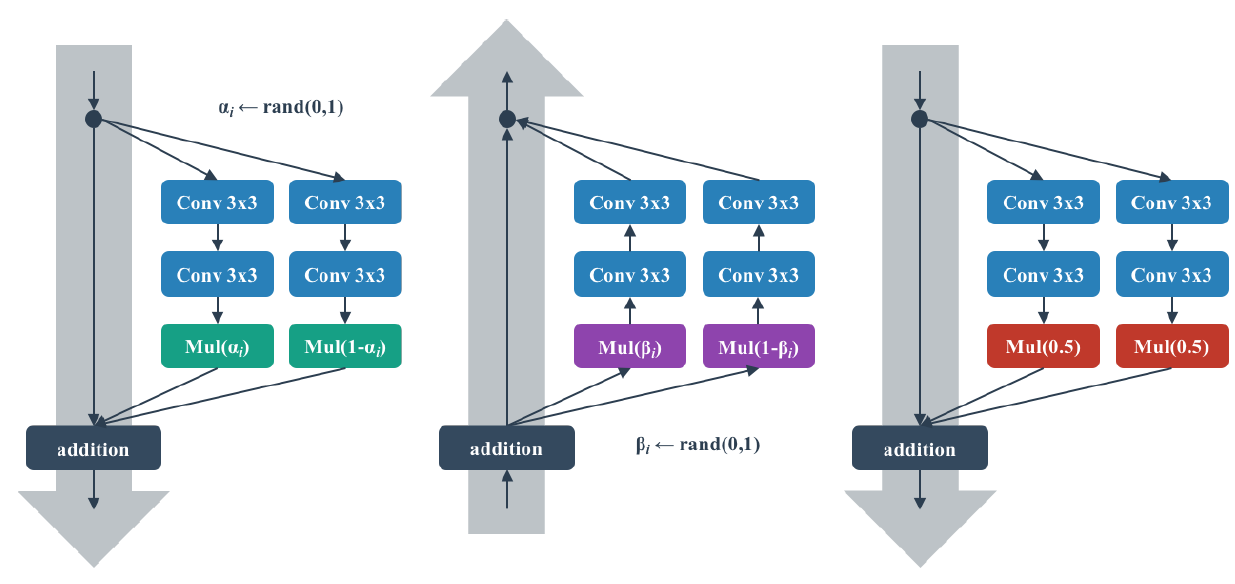

###  Shake-Shake regularization is actually an augmentation method of internal representation of features inside resnet . THe above image shows the augmentations added in blocks of resnets .

Image Courtesy :
https://towardsdatascience.com/review-shake-shake-regularization-image-classification-d22bb8587953

V1: This is an implementation of shake-shake from Heng's Discussion pointers . It is present in the discussion , however I will provide the github references somewhere .


In [ ]:
## Load Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import gc
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

## This library is for augmentations .
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    
    RandomGamma,
    ShiftScaleRotate ,
    GaussNoise,
    Blur,
    MotionBlur,   
    GaussianBlur,
)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
##Path for data 
PATH = '../input/bengaliai-cv19/'

In [ ]:
## Model configuration dictionary
  model_config ={
    "arch": "shake_shake",
    "input_shape": (1, 1, 128, 128),
    "n_classes": 10,
    "base_channels": 32,
    "depth": 26,
    "shake_forward": True,
    "shake_backward": True,
    "shake_image": True
  }

#### Data setup part 

In [ ]:
## Create Data from Parquet file mixing the methods of @hanjoonzhoe and @Iafoss

## Create Crop Function @Iafoss

HEIGHT = 137
WIDTH = 236
SIZE = 128

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

def Resize(df,size=128):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
       # image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        image0 = 255 - df.loc[df.index[i]].values.reshape(137,236).astype(np.uint8)
    #normalize each image by its max val
        img = (image0*(255.0/image0.max())).astype(np.uint8)
        image = crop_resize(img)
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized



In [ ]:
"""%%time
##Feather data generation for all train_data
for i in range(4):
    data = pd.read_parquet(PATH+f'train_image_data_{i}.parquet')
    data =Resize(data)
    data.to_feather(f'train_data_{i}{i}_l.feather')
    del data
    gc.collect()""" 
##TO save RAM I have run this command in another kernel and kept the output for the Kernel as dataset for this Kernel .

In [ ]:
DATA_PATH = "../input/pytorch-efficientnet-starter-kernel/"

In [ ]:
## Load Feather Data 
train = pd.read_csv(PATH + "train.csv")
data0 = pd.read_feather(DATA_PATH+"train_data_00_l.feather")
data1 = pd.read_feather(DATA_PATH+'train_data_11_l.feather')
data2 = pd.read_feather(DATA_PATH+'train_data_22_l.feather')
data3 = pd.read_feather(DATA_PATH+'train_data_33_l.feather')
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3
gc.collect()
data_full.shape

In [ ]:
## A bunch of code copied from internet . Half of them I dont understand yet . However , CutOut is used in this notebook
##https://github.com/hysts/pytorch_image_classification
import numpy as np
import torch
import torch.nn as nn

class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        image[ymin:ymax, xmin:xmax] = self.mask_color
        return image


class DualCutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.cutout = Cutout(mask_size, p, cutout_inside, mask_color)

    def __call__(self, image):
        return np.hstack([self.cutout(image), self.cutout(image)])


class DualCutoutCriterion:
    def __init__(self, alpha):
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss(reduction='mean')

    def __call__(self, preds, targets):
        preds1, preds2 = preds
        return (self.criterion(preds1, targets) + self.criterion(
            preds2, targets)) * 0.5 + self.alpha * F.mse_loss(preds1, preds2)


def mixup(data, targets, alpha, n_classes):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = (targets, shuffled_targets, lam)

    return data, targets


def mixup_criterion(preds, targets):
    targets1, targets2, lam = targets
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(
        preds, targets2)
    


class RandomErasing:
    def __init__(self, p, area_ratio_range, min_aspect_ratio, max_attempt):
        self.p = p
        self.max_attempt = max_attempt
        self.sl, self.sh = area_ratio_range
        self.rl, self.rh = min_aspect_ratio, 1. / min_aspect_ratio

    def __call__(self, image):
        image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]
        image_area = h * w

        for _ in range(self.max_attempt):
            mask_area = np.random.uniform(self.sl, self.sh) * image_area
            aspect_ratio = np.random.uniform(self.rl, self.rh)
            mask_h = int(np.sqrt(mask_area * aspect_ratio))
            mask_w = int(np.sqrt(mask_area / aspect_ratio))

            if mask_w < w and mask_h < h:
                x0 = np.random.randint(0, w - mask_w)
                y0 = np.random.randint(0, h - mask_h)
                x1 = x0 + mask_w
                y1 = y0 + mask_h
                image[y0:y1, x0:x1] = np.random.uniform(0, 1)
                break

        return image  

In [ ]:
## Add Augmentations as suited from Albumentations library
train_aug = Compose([ 
    ShiftScaleRotate(p=1,border_mode=cv2.BORDER_CONSTANT,value =1),
    OneOf([
        ElasticTransform(p=0.1, alpha=1, sigma=50, alpha_affine=50,border_mode=cv2.BORDER_CONSTANT,value =1),
        GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT,value =1, p=0.1),
        OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT,value =1)                  
        ], p=0.3),
    OneOf([
        GaussNoise(var_limit=1.0),
        Blur(),
        GaussianBlur(blur_limit=3)
        ], p=0.4),    
    RandomGamma(p=0.8)])

## A lot of heavy augmentations

In [ ]:
## Someone asked for normalization of images . values collected from Iafoss


class ToTensor:
    def __call__(self, data):
        if isinstance(data, tuple):
            return tuple([self._to_tensor(image) for image in data])
        else:
            return self._to_tensor(data)

    def _to_tensor(self, data):
        if len(data.shape) == 3:
            return torch.from_numpy(data.transpose(2, 0, 1).astype(np.float32))
        else:
            return torch.from_numpy(data[None, :, :].astype(np.float32))


class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = np.asarray(image).astype(np.float32) / 255.
        image = (image - self.mean) / self.std
        return image

In [ ]:
## Create dataset function
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =False,aug=train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(np.float)
        image = self.data[idx, :].reshape(128,128).astype(np.float)
        if self.transform:
            augment = self.aug(image =image)
            image = augment['image']
            cutout = Cutout(32,0.5,True,1)
            image = cutout(image)
        norm = Normalize([0.0692],[0.2051])
        image = norm(image)

        return image,label1,label2,label3

In [ ]:
## Do a train-valid split of the data to create dataset and dataloader . Specify random seed to get reproducibility 
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.20, random_state=42,shuffle =True) ## split data
del data_full 
gc.collect()

In [ ]:
##Creating the train and valid dataset for training . Training data has the transform flag ON
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = False) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 
torch.cuda.empty_cache()
gc.collect()

In [ ]:
##Visulization function for checking Original and augmented image
def visualize(original_image,aug_image):
    fontsize = 18
    
    f, ax = plt.subplots(1, 2, figsize=(8, 8))

    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)
    

In [ ]:
## One image taken from raw dataframe another from dataset 
orig_image = data_train_df.iloc[0, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[0][0]

In [ ]:
## Check the augmentations 
for i in range (20):
    aug_image = train_dataset[0][0]
    visualize (orig_image,aug_image)

In [ ]:
del train_df,valid_df,data_train_df,data_valid_df 
torch.cuda.empty_cache()
gc.collect()

In [ ]:
## Create data loader and get ready for training .
batch_size = 32 
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)


#### Model creation part 

In [ ]:
## Mish Activation Function Not yet Used . May be later 
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

In [ ]:
## Over9000 Optimizer . Inspired by Iafoss . Over and Out !
##https://github.com/mgrankin/over9000/blob/master/ralamb.py
import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Lookahead implementation from https://github.com/rwightman/pytorch-image-models/blob/master/timm/optim/lookahead.py

""" Lookahead Optimizer Wrapper.
Implementation modified from: https://github.com/alphadl/lookahead.pytorch
Paper: `Lookahead Optimizer: k steps forward, 1 step back` - https://arxiv.org/abs/1907.08610
"""
import torch
from torch.optim.optimizer import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
     adam = Adam(params, *args, **kwargs)
     return Lookahead(adam, alpha, k)


# RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

RangerLars = Over9000 

In [ ]:
## Shake Function 

import torch
from torch.autograd import Function


class ShakeFunction(Function):
    @staticmethod
    def forward(ctx, x1, x2, alpha, beta):
        ctx.save_for_backward(x1, x2, alpha, beta)

        y = x1 * alpha + x2 * (1 - alpha)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x1, x2, alpha, beta = ctx.saved_variables
        grad_x1 = grad_x2 = grad_alpha = grad_beta = None

        if ctx.needs_input_grad[0]:
            grad_x1 = grad_output * beta
        if ctx.needs_input_grad[1]:
            grad_x2 = grad_output * (1 - beta)

        return grad_x1, grad_x2, grad_alpha, grad_beta


shake_function = ShakeFunction.apply


def get_alpha_beta(batch_size, shake_config, device):
    forward_shake, backward_shake, shake_image = shake_config

    if forward_shake and not shake_image:
        alpha = torch.rand(1)
    elif forward_shake and shake_image:
        alpha = torch.rand(batch_size).view(batch_size, 1, 1, 1)
    else:
        alpha = torch.FloatTensor([0.5])

    if backward_shake and not shake_image:
        beta = torch.rand(1)
    elif backward_shake and shake_image:
        beta = torch.rand(batch_size).view(batch_size, 1, 1, 1)
    else:
        beta = torch.FloatTensor([0.5])

    alpha = alpha.to(device)
    beta = beta.to(device)

    return alpha, beta

In [ ]:
## shake-shake network
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()


class ResidualPath(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResidualPath, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(x, inplace=False)
        x = F.relu(self.bn1(self.conv1(x)), inplace=False)
        x = self.bn2(self.conv2(x))
        return x


class DownsamplingShortcut(nn.Module):
    def __init__(self, in_channels):
        super(DownsamplingShortcut, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.conv2 = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn = nn.BatchNorm2d(in_channels * 2)

    def forward(self, x):
        x = F.relu(x, inplace=False)
        y1 = F.avg_pool2d(x, kernel_size=1, stride=2, padding=0)
        y1 = self.conv1(y1)

        y2 = F.pad(x[:, :, 1:, 1:], (0, 1, 0, 1))
        y2 = F.avg_pool2d(y2, kernel_size=1, stride=2, padding=0)
        y2 = self.conv2(y2)

        z = torch.cat([y1, y2], dim=1)
        z = self.bn(z)

        return z


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, shake_config):
        super(BasicBlock, self).__init__()

        self.shake_config = shake_config

        self.residual_path1 = ResidualPath(in_channels, out_channels, stride)
        self.residual_path2 = ResidualPath(in_channels, out_channels, stride)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module('downsample',
                                     DownsamplingShortcut(in_channels))

    def forward(self, x):
        x1 = self.residual_path1(x)
        x2 = self.residual_path2(x)

        if self.training:
            shake_config = self.shake_config
        else:
            shake_config = (False, False, False)

        alpha, beta = get_alpha_beta(x.size(0), shake_config, x.device)
        y = shake_function(x1, x2, alpha, beta)

        return self.shortcut(x) + y


class Network(nn.Module):
    def __init__(self, config):
        super(Network, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        depth = config['depth']
        self.shake_config = (config['shake_forward'], config['shake_backward'],
                             config['shake_image'])

        block = BasicBlock
        n_blocks_per_stage = (depth - 2) // 6
        assert n_blocks_per_stage * 6 + 2 == depth

        n_channels = [base_channels, base_channels * 2, base_channels * 4]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage, block, stride=1)
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, block, stride=2)
        self.stage3 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, block, stride=2)

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]

        #self.fc = nn.Linear(self.feature_size, n_classes)
        # vowel_diacritic
        self.fc1 = nn.Linear(self.feature_size,11)
        # grapheme_root
        self.fc2 = nn.Linear(self.feature_size,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(self.feature_size,7)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name,
                    block(
                        in_channels,
                        out_channels,
                        stride=stride,
                        shake_config=self.shake_config))
            else:
                stage.add_module(
                    block_name,
                    block(
                        out_channels,
                        out_channels,
                        stride=1,
                        shake_config=self.shake_config))
        return stage

    def _forward_conv(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2= self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

In [ ]:
## Make sure we are using the GPU . Get CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
## Load model and pass desired parameters in config
def load_model(config):
    #module = importlib.import_module('models.{}'.format(config['arch']))
    #Network = getattr(module, 'Network')
    return Network(config)

model = load_model(model_config)
model = model.to(device)

In [ ]:
## A Small but useful test of the Model by using dummy input . .
x = torch.zeros((32,1, 64, 64))
with torch.no_grad():
    output1,output2,output3 =model(x.cuda())
print(output3.shape)

In [ ]:
## This is a placeholder for finetunign or inference when you want to load a previously trained model
##and want to finetune or want to do just inference

##model.load_state_dict(torch.load('../input/bengef2/effnetb0_trial_stage1.pth'))  
## There is a small thing . I trained using effnetb4 offline for 20 epochs and loaded the weight
## I forgot to change the naming convension and it still reads effnetb0 . But this is actually effnetb4

In [ ]:
n_epochs = 1 ## 1 Epoch as sample . "I am just a poor boy  , no GPU in reality "

#optimizer =torch.optim.Adam(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 2e-4) ## This didnt give good result need to correct  and get the right scheduler .
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3) ## New once 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-2, total_steps=None, epochs=n_epochs, steps_per_epoch=5021, pct_start=0.0,
                                   anneal_strategy='cos', cycle_momentum=True,base_momentum=0.85, max_momentum=0.95,  div_factor=100.0) ## Scheduler . Step for each batch
criterion = nn.CrossEntropyLoss()
batch_size=32

In [ ]:
##Local Metrics implementation .
##https://www.kaggle.com/corochann/bengali-seresnext-training-with-pytorch
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score

def macro_recall_multi(pred_graphemes, true_graphemes,pred_vowels,true_vowels,pred_consonants,true_consonants, n_grapheme=168, n_vowel=11, n_consonant=7):
    #pred_y = torch.split(pred_y, [n_grapheme], dim=1)
    pred_label_graphemes = torch.argmax(pred_graphemes, dim=1).cpu().numpy()

    true_label_graphemes = true_graphemes.cpu().numpy()
    
    pred_label_vowels = torch.argmax(pred_vowels, dim=1).cpu().numpy()

    true_label_vowels = true_vowels.cpu().numpy()
    
    pred_label_consonants = torch.argmax(pred_consonants, dim=1).cpu().numpy()

    true_label_consonants = true_consonants.cpu().numpy()    
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_label_graphemes, true_label_graphemes, average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_label_vowels, true_label_vowels, average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_label_consonants, true_label_consonants, average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    #print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

#### Training and validation part 

In [ ]:
## This function for train is copied from @hanjoonchoe
## We are going to train and track accuracy and then evaluate and track validation accuracy
def train(epoch,history):
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  running_recall = 0.0
  for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader),total=len(train_loader)):
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()
      outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
      loss1 = 0.1*criterion(outputs1,labels1)
      loss2 = 0.7* criterion(outputs2,labels2)
      loss3 = 0.2*criterion(outputs3,labels3)
      running_loss += loss1.item()+loss2.item()+loss3.item()
      running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      optimizer.zero_grad()
      acc = running_acc/total
      scheduler.step()
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print(' train epoch : {}\tacc : {:.2f}%'.format(epoch,running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
    
  print('recall: {:.4f}'.format(running_recall/len(train_loader)))
  total_train_recall = running_recall/len(train_loader)
  torch.cuda.empty_cache()
  gc.collect()
  history.loc[epoch, 'train_loss'] = losses[0]
  history.loc[epoch,'train_acc'] = accs[0].cpu().numpy()
  history.loc[epoch,'train_recall'] = total_train_recall
  return  total_train_recall
def evaluate(epoch,history):
   model.eval()
   losses = []
   accs = []
   recalls = []
   acc= 0.0
   total = 0.0
   #print('epochs {}/{} '.format(epoch+1,epochs))
   running_loss = 0.0
   running_acc = 0.0
   running_recall = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criterion(outputs1,labels1)
        loss2 = 2*criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        running_loss += loss1.item()+loss2.item()+loss3.item()
        running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        acc = running_acc/total
        #scheduler.step()
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   recalls.append(running_recall/len(valid_loader))
   total_recall = running_recall/len(valid_loader) ## No its not Arnold Schwarzenegger movie
   print('val epoch: {} \tval acc : {:.2f}%'.format(epoch,running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))
   print('recall: {:.4f}'.format(running_recall/len(valid_loader)))
   history.loc[epoch, 'valid_loss'] = losses[0]
   history.loc[epoch, 'valid_acc'] = accs[0].cpu().numpy()
   history.loc[epoch, 'valid_recall'] = total_recall
   return  total_recall


In [ ]:
## A very simple loop to train for number of epochs it probably can be made more robust to save only the file with best valid loss 
history = pd.DataFrame()
n_epochs = 1 ## 1 Epoch as sample . "I am just a poor boy  , no GPU in reality "
valid_recall = 0.0
best_valid_recall = 0.0
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_recall = train(epoch,history)
    valid_recall = evaluate(epoch,history)
    if valid_recall > best_valid_recall:
        print(f'Validation recall has increased from:  {best_valid_recall:.4f} to: {valid_recall:.4f}. Saving checkpoint')
        torch.save(model.state_dict(), 'effnetb0_trial_stage1.pth') ## Saving model weights based on best validation accuracy.
        best_valid_recall = valid_recall ## Set the new validation Recall score to compare with next epoch
        
        
    #scheduler.step() ## Want to test with fixed learning rate .If you want to use scheduler please uncomment this .
    

In [ ]:
history.to_csv('history.csv')
history.head()

#### Inference part 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [ ]:
## Load model for inferernce . 
#model.load_state_dict(torch.load('../input/pytorch-efficientnet-starter-code/effnetb0_trial_stage1.pth')) 

In [ ]:
test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')

In [ ]:
#check https://www.kaggle.com/iafoss/image-preprocessing-128x128

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [ ]:
class GraphemeDataset(Dataset):
    def __init__(self, fname):
        print(fname)
        self.df = pd.read_parquet(fname)
        self.data = 255 - self.df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name = self.df.iloc[idx,0]
        #normalize each image by its max val
        img = (self.data[idx]*(255.0/self.data[idx].max())).astype(np.uint8)
        img = crop_resize(img)
        img = img.astype(np.float32)/255.0
        return img, name

In [ ]:
## All test data
test_data = ['/kaggle/input/bengaliai-cv19/test_image_data_0.parquet','/kaggle/input/bengaliai-cv19/test_image_data_1.parquet','/kaggle/input/bengaliai-cv19/test_image_data_2.parquet',
             '/kaggle/input/bengaliai-cv19/test_image_data_3.parquet']

In [ ]:
%%time
## Inference a little faster using @Iafoss and  @peters technique
row_id,target = [],[]
for fname in test_data:
    #data = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/{fname}')
    test_image = GraphemeDataset(fname)
    dl = torch.utils.data.DataLoader(test_image,batch_size=128,num_workers=4,shuffle=False)
    with torch.no_grad():
        for x,y in tqdm(dl):
            x = x.unsqueeze(1).float().cuda()
            p1,p2,p3 = model(x)
            p1 = p1.argmax(-1).view(-1).cpu()
            p2 = p2.argmax(-1).view(-1).cpu()
            p3 = p3.argmax(-1).view(-1).cpu()
            for idx,name in enumerate(y):
                row_id += [f'{name}_vowel_diacritic',f'{name}_grapheme_root',
                           f'{name}_consonant_diacritic']
                target += [p1[idx].item(),p2[idx].item(),p3[idx].item()]
                
sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv('submission.csv', index=False)
sub_df.head(20)